In [1]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (_, _) = mnist.load_data()

In [2]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # [-1, 1]로 정규화

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [4]:
#미니배치로 나누고 섞기
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
#모형 생성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, BatchNormalization
def make_generator_model():
    model = Sequential()
    
    # use_bias=F: bias를 생성하지 않음
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256))) # 출력된 값을 reshape
    
    # 역합성곱층
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    return model

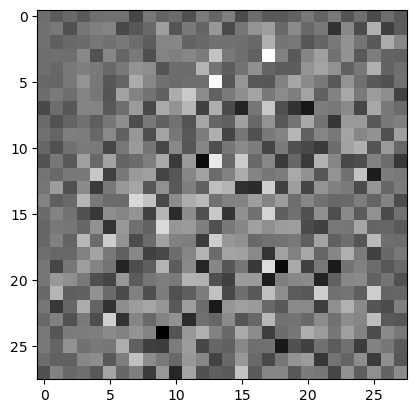

In [6]:
#생성 모형 테스트
import matplotlib.pyplot as plt
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [8]:
#판별 모형
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00134676]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
# 판별모형 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
# 생성모형 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
import os
checkpoint_dir = 'c:/data/mnist/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # 이미지 생성
        # 이미지 판독
        real_output = discriminator(images, training=True) 
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))


In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) #추론모드: 순전파만 하고 역전파가 없는 상태
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [28]:
import time
from IPython import display
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        # GIF 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

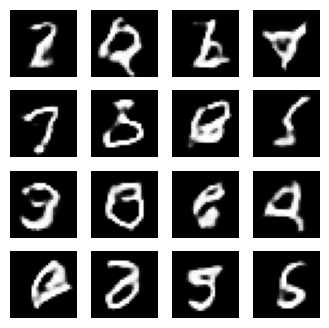

Wall time: 32min 35s


In [29]:
%%time
train(train_dataset, EPOCHS)

In [30]:
#체크 포인트 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

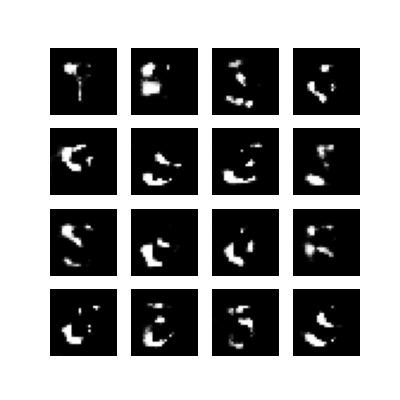

In [31]:
#gif 생성
import imageio
import glob
anim_file = 'c:/data/mnist/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.v2.imread(filename)
        writer.append_data(image)
    image = imageio.v2.imread(filename)
    writer.append_data(image)
display.Image(filename=anim_file)

In [32]:
generator.save('c:/data/model/iris_generator.h5')

In [33]:
import tensorflow as tf
generator = tf.keras.models.load_model('c:/data/model/iris_generator.h5')
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

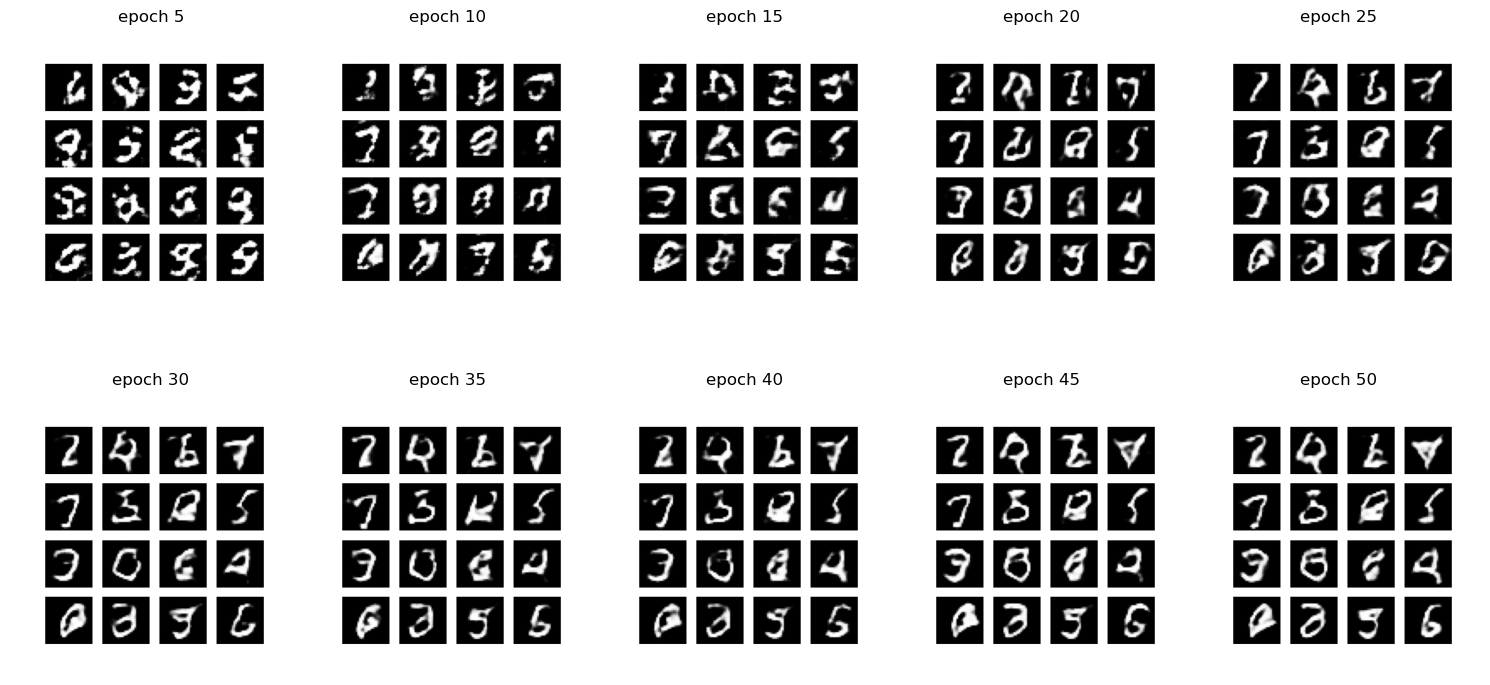

In [34]:
from matplotlib import pyplot as plt
import math
import PIL
plt.figure(figsize=(15,8))
for i in range(4,50,5):
    plt.subplot(2, 5, math.ceil((i+1)/5))
    img=PIL.Image.open('image_at_epoch_{:04d}.png'.format(i))
    plt.imshow(img, 'gray')
    plt.title(f'epoch {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

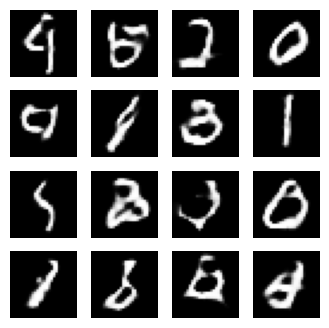

In [35]:
#모형 테스트
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

predictions = generator(seed, training=False) 

fig = plt.figure(figsize=(4,4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')